<a href="https://colab.research.google.com/github/Narachii/tensorflow_basics/blob/NLP_basics/LSTM_Spam_Detenction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [5]:
# Fetch csv from Web site
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-04-28 16:42:16--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.05s   

2020-04-28 16:42:16 (9.60 MB/s) - ‘spam.csv’ saved [503663/503663]



In [0]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [18]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [19]:
# Drop columns
df = df[['v1', 'v2']]
df.columns = ['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# crate binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [0]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [0]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [32]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens' % V)
word2idx

Found 7265 unique tokens


{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'is': 8,
 'in': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'it': 13,
 'your': 14,
 'of': 15,
 'call': 16,
 'have': 17,
 '2': 18,
 'on': 19,
 'that': 20,
 'are': 21,
 'now': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'can': 26,
 'do': 27,
 'be': 28,
 'at': 29,
 "i'm": 30,
 'ur': 31,
 'or': 32,
 'if': 33,
 'get': 34,
 'will': 35,
 'with': 36,
 'just': 37,
 'we': 38,
 'no': 39,
 'this': 40,
 'gt': 41,
 'lt': 42,
 '4': 43,
 'up': 44,
 'when': 45,
 'ok': 46,
 'go': 47,
 'what': 48,
 'out': 49,
 'from': 50,
 'how': 51,
 'know': 52,
 'free': 53,
 'all': 54,
 'good': 55,
 'come': 56,
 'am': 57,
 'then': 58,
 'time': 59,
 'like': 60,
 'was': 61,
 'its': 62,
 'love': 63,
 'day': 64,
 'only': 65,
 'got': 66,
 'want': 67,
 'send': 68,
 'there': 69,
 'as': 70,
 'he': 71,
 'home': 72,
 'need': 73,
 'going': 74,
 'one': 75,
 'r': 76,
 'today': 77,
 'about': 78,
 'text': 79,
 "i'll": 80,
 'lor': 81,
 'txt': 82,
 'still': 83,
 'sorry': 84,


In [33]:
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [37]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [0]:
# Create the model

# embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [56]:
model.compile(
    loss= 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Traing model...')
r = model.fit(
    data_train, Ytrain,
    epochs=10,
    validation_data=(data_test, Ytest)
)

Traing model...
Epoch 1/10
117/117 [==============================] - 9s 77ms/step - loss: 0.0112 - accuracy: 0.9992 - val_loss: 0.0461 - val_accuracy: 0.9897
Epoch 2/10
117/117 [==============================] - 9s 73ms/step - loss: 0.0096 - accuracy: 0.9995 - val_loss: 0.0453 - val_accuracy: 0.9913
Epoch 3/10
117/117 [==============================] - 8s 70ms/step - loss: 0.0082 - accuracy: 0.9995 - val_loss: 0.0581 - val_accuracy: 0.9869
Epoch 4/10
117/117 [==============================] - 8s 71ms/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.0524 - val_accuracy: 0.9902
Epoch 5/10
117/117 [==============================] - 8s 72ms/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.0539 - val_accuracy: 0.9886
Epoch 6/10
117/117 [==============================] - 8s 72ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0520 - val_accuracy: 0.9902
Epoch 7/10
117/117 [==============================] - 8s 72ms/step - loss: 0.0070 - accuracy: 0.9989 - val_loss: 0.0685 - val_

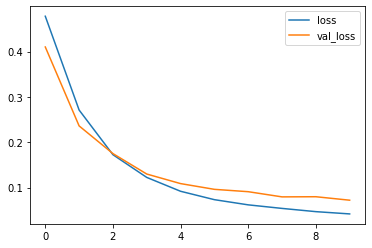

In [42]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

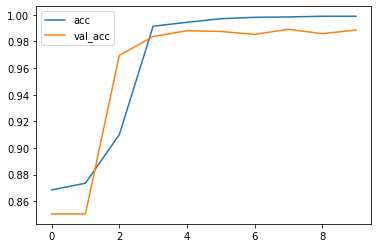

In [43]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()